<a href="https://colab.research.google.com/github/carolinavegatw/datastudy/blob/main/Modelo_Machine_learning_oficial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
#Importando as bibliotecas
import numpy as np
import pandas as pd
import re # for regex expresoes regulares
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
dataset = pd.read_csv('/content/drive/MyDrive/dados sensores/review_clientes_melhores_compras (1).csv')


In [8]:
dataset.head(1000)

,review_id,review_cliente,sentimento
0,e64fb393e7b32834bb789ff8bb30750e,receber bem antar prazo estipular,1
1,f7c4243c7fe1938f181bec41a392bdeb,parabens melhores compras adorar comprar inter...,1
2,8670d52e15e00043ae7de4c01cc2fe06,recomendar aparelhar eficiente site marcar apa...,1
3,4b49719c8a200003f700d3d986ea1a19,pouco travar valor ta bom,1
4,3948b09f7c818e2d86c9a546758b2335,super recomendar vendedor confiavel produto ok...,1
...,...,...,...
995,23f1e050fff1a3cfdc4e4ebd068e8406,imagem mostrar foto diferente produto receber,0
996,a16d7831ada4217c64f89225d1fd000e,comprar voltagem vir v,0
997,1299de51d55c2c4e37ca6bc17a23a5f4,entregar perfeito bem antar datar previsto,1
998,9e96e689ed29ef49d22e6e837da4e606,adorar produto ainda nao colocar lugar testar ...,1


In [9]:
dataset.groupby("sentimento").count()


,review_id,review_cliente
sentimento,,
0,15060,15060
1,27831,27831


In [10]:
# Expressões regulares - limpeza dos dados - remover tags, caracteres especiais, links, menções, e setar tudo para lower case
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df


clean_dataset = standardize_text(dataset, "review_cliente")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [11]:
clean_dataset

,review_id,review_cliente,sentimento
0,e64fb393e7b32834bb789ff8bb30750e,receber bem antar prazo estipular,1
1,f7c4243c7fe1938f181bec41a392bdeb,parabens melhores compras adorar comprar inter...,1
2,8670d52e15e00043ae7de4c01cc2fe06,recomendar aparelhar eficiente site marcar apa...,1
3,4b49719c8a200003f700d3d986ea1a19,pouco travar valor ta bom,1
4,3948b09f7c818e2d86c9a546758b2335,super recomendar vendedor confiavel produto ok...,1
...,...,...,...
42886,df5fae90e85354241d5d64a8955b2b09,entregar dentro prazo produto chegar condicao ...,1
42887,a709d176f59bc3af77f4149c96bae357,produto nao enviar nf nao existir vender nf ce...,0
42888,b3de70c89b1510c4cd3d0649fd302472,excelente mochila entregar super rapido super ...,1
42889,be360f18f5df1e0541061c87021e6d93,solicitar comprar capar retrovisor celta prism...,0


In [12]:
#Eliminar stopwords do dataset
import nltk

nltk.download('stopwords')
nltk.download('punkt')

def rem_stopwords(text):
  stop_words=set(stopwords.words('portuguese'))
  words=word_tokenize(text)
  return [w for w in words if w not in stop_words]

clean_dataset.review_cliente=dataset.review_cliente.apply(rem_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [13]:
#Stem trabalho de gramatica
def stem_txt(text):
  ss=SnowballStemmer('portuguese')
  return " ".join([ss.stem(w)for w in text])

clean_dataset.review_cliente=dataset.review_cliente.apply(stem_txt)


In [14]:
clean_dataset.head()

,review_id,review_cliente,sentimento
0,e64fb393e7b32834bb789ff8bb30750e,receb bem antar praz estipul,1
1,f7c4243c7fe1938f181bec41a392bdeb,parabens melhor compr ador compr internet segu...,1
2,8670d52e15e00043ae7de4c01cc2fe06,recomend aparelh eficient sit marc aparelh imp...,1
3,4b49719c8a200003f700d3d986ea1a19,pouc trav valor ta bom,1
4,3948b09f7c818e2d86c9a546758b2335,sup recomend vendedor confiavel produt ok entr...,1


Criando e Treinando os modelos

In [15]:
# Construindo bag-of-words com count-vectorizer
count_vectorizer = CountVectorizer()

# Separando o texto da variável alvo
list_review = np.array(clean_dataset.review_cliente.values)
list_sentimento = np.array(clean_dataset.sentimento.values)

# Aprendendo o vacabulário e contabilizando os termos para teste
list_review = count_vectorizer.fit_transform(clean_dataset.review_cliente).toarray()

# Construindo exemplos para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(list_review, list_sentimento, test_size=0.2, 
                                                                                random_state=40)


In [16]:
#Aplicando os modelos e treinando

gnb,mnb,bnb = GaussianNB(), MultinomialNB(alpha=1.0, fit_prior=True), BernoulliNB(alpha=1.0, fit_prior=True)

gnb.fit(X_train, y_train)
mnb.fit(X_train, y_train)
bnb.fit(X_train,y_train)

BernoulliNB()

In [17]:
#Dados de treinamento dos modelos
ypg=gnb.predict(X_test)
ypm=mnb.predict(X_test)
ypb=bnb.predict(X_test)

In [18]:
# Método para extração das métricas de avaliação usando a parte dos dados que separamos para teste.
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, ypg)
print("Gaussian= accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
accuracy, precision, recall, f1 = get_metrics(y_test, ypm)
print("Multinomial= accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
accuracy, precision, recall, f1 = get_metrics(y_test, ypb)
print("Bernoulli= accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))


Gaussian= accuracy = 0.705, precision = 0.710, recall = 0.705, f1 = 0.654
Multinomial= accuracy = 0.887, precision = 0.887, recall = 0.887, f1 = 0.887
Bernoulli= accuracy = 0.856, precision = 0.854, recall = 0.856, f1 = 0.854


Matriz de confusão e Curva Roc.

In [44]:
#matriz de confusao com Gaussian
mc_gaussian = confusion_matrix(y_test, ypg)
tn, fp,fn,tp = mc_gaussian.ravel()

mc_gaussian= np.array([[tp,fn], [fp,tn]])

mc_gaussian


array([[5312,  280],
       [2254,  733]])

Text(1.3, 1.5, 'TN')

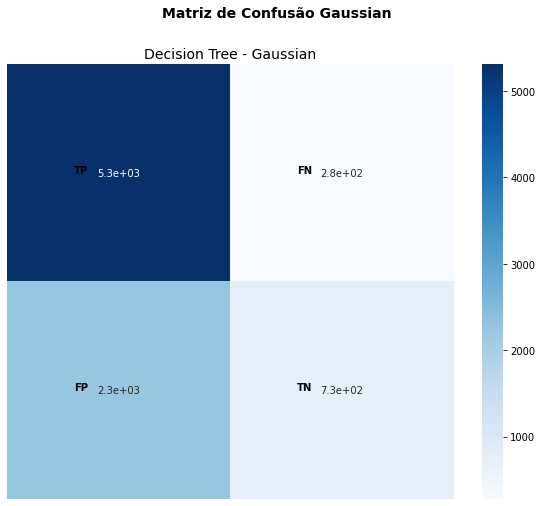

In [56]:
#Visualização Gráfica da Matriz de Confusão- Gaussian
modelo_title = 'Decision Tree - Gaussian'
fig = plt.figure(figsize=(10,8))
fig.suptitle('Matriz de Confusão Gaussian', fontsize=14, fontweight='bold')

sns.heatmap(mc_gaussian, cmap='Blues', annot=True)

plt.title(modelo_title, fontsize=14)

plt.xticks([])
plt.yticks([])

plt.annotate('TP', (0.3,0.5), fontweight='bold')
plt.annotate('FN', (1.3,0.5), fontweight='bold')
plt.annotate('FP', (0.3,1.5), fontweight='bold')
plt.annotate('TN', (1.3,1.5), fontweight='bold')



In [45]:
#matriz de confusao com Multinomial
mc_multinomial= confusion_matrix(y_test, ypm)
tn, fp,fn,tp = mc_multinomial.ravel()

mc_multinomial= np.array([[tp,fn], [fp,tn]])

mc_multinomial



array([[5084,  508],
       [ 462, 2525]])

Text(1.3, 1.5, 'TN')

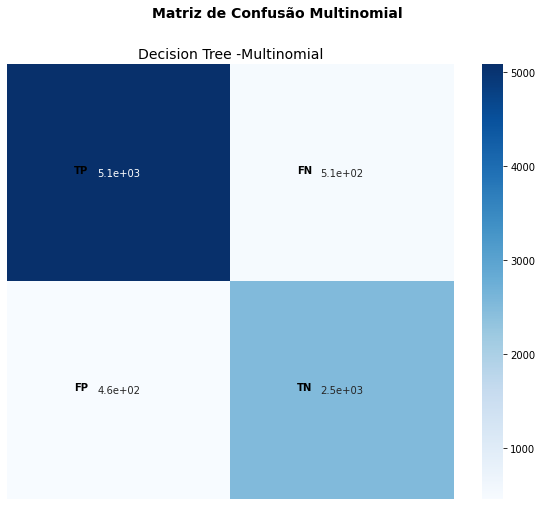

In [57]:
#Visualização Gráfica da Matriz de Confusão- Mutlinomial
modelo_title = 'Decision Tree -Multinomial'
fig = plt.figure(figsize=(10,8))
fig.suptitle('Matriz de Confusão Multinomial', fontsize=14, fontweight='bold')

sns.heatmap(mc_multinomial, cmap='Blues', annot=True)

plt.title(modelo_title, fontsize=14)

plt.xticks([])
plt.yticks([])

plt.annotate('TP', (0.3,0.5), fontweight='bold')
plt.annotate('FN', (1.3,0.5), fontweight='bold')
plt.annotate('FP', (0.3,1.5), fontweight='bold')
plt.annotate('TN', (1.3,1.5), fontweight='bold')


In [46]:
#matriz de confusao com Bernoulli
mc_bernoulli = confusion_matrix(y_test, ypb)
tn, fp,fn,tp = mc_bernoulli.ravel()

mc_bernoulli= np.array([[tp,fn], [fp,tn]])

mc_bernoulli

array([[5064,  528],
       [ 711, 2276]])

Text(1.3, 1.5, 'TN')

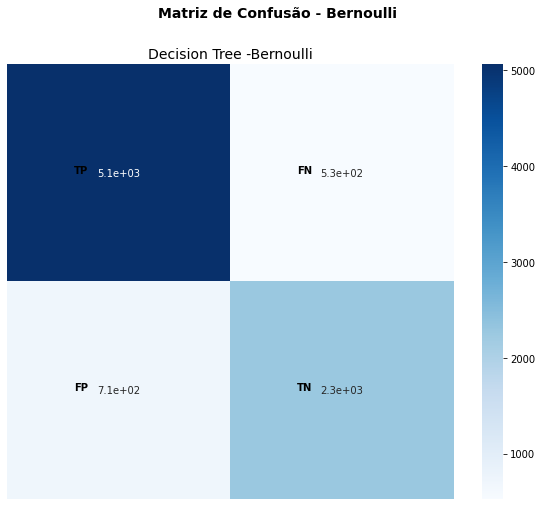

In [58]:
#Visualização Gráfica da Matriz de Confusão- Bernoulli
modelo_title = 'Decision Tree -Bernoulli'
fig = plt.figure(figsize=(10,8))
fig.suptitle('Matriz de Confusão - Bernoulli', fontsize=14, fontweight='bold')

sns.heatmap(mc_bernoulli, cmap='Blues', annot=True)

plt.title(modelo_title, fontsize=14)

plt.xticks([])
plt.yticks([])

plt.annotate('TP', (0.3,0.5), fontweight='bold')
plt.annotate('FN', (1.3,0.5), fontweight='bold')
plt.annotate('FP', (0.3,1.5), fontweight='bold')
plt.annotate('TN', (1.3,1.5), fontweight='bold')


In [54]:
#calculando Dados para curva ROC

r_auc = roc_auc_score(y_test, ypm)
r_fpr, r_tpr,_ = roc_curve(y_test, ypm)

r_auc_b = roc_auc_score(y_test, ypb)
r_fpr_b, r_tpr_b,_ = roc_curve(y_test, ypb)

r_auc_g = roc_auc_score(y_test, ypg)
r_fpr_g, r_tpr_g,_ = roc_curve(y_test, ypg)

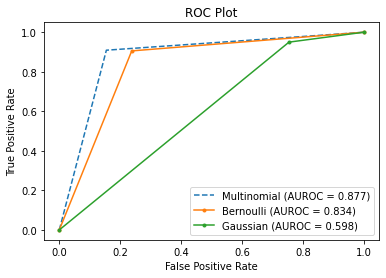

In [55]:
plt.plot(r_fpr, r_tpr, linestyle='--', label='Multinomial (AUROC = %0.3f)' % r_auc)
plt.plot(r_fpr_b, r_tpr_b, marker='.', label='Bernoulli (AUROC = %0.3f)' % r_auc_b)
plt.plot(r_fpr_g, r_tpr_g, marker='.', label='Gaussian (AUROC = %0.3f)' % r_auc_g)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()